In [51]:
#IGF2BP3 D00214.001 (Wang T et al., Nat Commun. 2018.)
#LIN28A D00118.001 (Ref: Yang DH et al., Mol Cell Biol. 2010.)
#YBX1 D00163.001 (Evdokimova V et al., Nat Cell Biol. 2006.)

In [52]:
import rpy2.ipython
%load_ext rpy2.ipython
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [53]:
%%R 
library(tidyverse)
library(corrplot)
library(ggrepel)
library(patchwork)

In [54]:
%%R 
# Load expression data
exp_df <- read_tsv('data/BRCA_SLAM_gs_TPM.selected.txt')
exp_genes <- exp_df$GENE
exp_df <- exp_df %>% 
  select(-GENE) %>%
  as.data.frame()
rownames(exp_df) <- exp_genes
exp_df <- exp_df[rowSums(exp_df) > 10, ]
exp_df <- log10(exp_df + 1e-6)
print(paste("Expression data:", nrow(exp_df), "genes x", ncol(exp_df), "samples"))

Rows: 56517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): GENE
dbl (12): HCC1806-PAR-1, HCC1806-PAR-2, MDA-PAR-1, MDA-PAR-2, MCF7-1, MCF7-2...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] "Expression data: 12388 genes x 12 samples"


In [55]:
%%R 
# Load decay rate data
decay_df <- read_tsv('data/BRCA-lines_log10_decay_rates_gs.txt')
decay_genes <- decay_df$...1
decay_df <- decay_df %>% 
  select(-...1) %>%
  as.data.frame()
rownames(decay_df) <- decay_genes
colnames(decay_df) <- gsub("\\.", "-", colnames(decay_df))
print(paste("Decay data:", nrow(decay_df), "genes x", ncol(decay_df), "samples"))

New names:
• `` -> `...1`
Rows: 8789 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): ...1
dbl (12): HCC1806.PAR.1, HCC1806.PAR.2, MDA.PAR.1, MDA.PAR.2, MCF7.1, MCF7.2...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] "Decay data: 8789 genes x 12 samples"


In [56]:
%%R 
binding_df <- read_tsv('/avicenna/genomes/deepbind_ensemble/gene_vs_model_binarized_3sigma.txt')
print(paste("Binding data:", nrow(binding_df), "genes x", ncol(binding_df), "models"))

# Define RBPs of interest and their DeepBind models
rbps <- list(
  "RBMS3" = NULL,  # Will use existing motif map
  "IGF2BP3" = "D00214.001",
  "LIN28A" = "D00118.001",
  "YBX1" = "D00163.001"
)

Rows: 18484 Columns: 105
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (3): txid, gene_id, gene_name
dbl (102): D00084.001, D00085.001, D00087.001, D00208.001, D00225.001, D0020...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] "Binding data: 18484 genes x 105 models"


In [57]:
%%R
rbms3_targets <- readLines("results/rbms3_reg.list")
print(paste("RBMS3 targets from file:", length(rbms3_targets)))  # Should be 3,716

[1] "RBMS3 targets from file: 3716"


In [58]:
%%R 
# Verify they're in decay data
targets_in_decay <- intersect(rbms3_targets, rownames(decay_df))
print(paste("RBMS3 targets in decay data:", length(targets_in_decay)))  # Should be 3,716

[1] "RBMS3 targets in decay data: 3716"


In [59]:
%%R 
# Get targets for other RBPs from binding data
rbp_targets <- list()
rbp_targets[["RBMS3"]] <- rbms3_targets

for (rbp_name in names(rbps)) {
  if (!is.null(rbps[[rbp_name]])) {
    model_id <- rbps[[rbp_name]]
    if (model_id %in% colnames(binding_df)) {
      targets <- binding_df$gene_name[binding_df[[model_id]] == 1]
      rbp_targets[[rbp_name]] <- targets
      print(paste(rbp_name, "targets from", model_id, ":", length(targets)))
    } else {
      print(paste("Warning:", model_id, "not found in binding data"))
    }
  }
}

[1] "IGF2BP3 targets from D00214.001 : 5015"
[1] "LIN28A targets from D00118.001 : 3606"
[1] "YBX1 targets from D00163.001 : 7851"


In [60]:
%%R 
calculate_rbp_correlations <- function(rbp_name, targets, exp_df, decay_df) {
  
  # Check if RBP is in expression data
  if (!rbp_name %in% rownames(exp_df)) {
    warning(paste(rbp_name, "not found in expression data"))
    return(NULL)
  }
  
  # Get RBP expression
  rbp_exp <- as.numeric(exp_df[rbp_name, ])
  names(rbp_exp) <- colnames(exp_df)
  
  # Get targets that exist in decay data
  targets_in_decay <- intersect(targets, rownames(decay_df))
  
  if (length(targets_in_decay) < 10) {
    warning(paste(rbp_name, "has too few targets in decay data:", length(targets_in_decay)))
    return(NULL)
  }
  
  print(paste("Processing", rbp_name, "with", length(targets_in_decay), "targets"))
  
  # Get regulon decay rates
  regulon_decay <- decay_df[targets_in_decay, ]
  
  # Calculate correlation for each target
  correlations <- c()
  for (i in 1:length(targets_in_decay)) {
    target <- targets_in_decay[i]
    target_decay <- as.numeric(decay_df[target, ])
    
    if (sum(!is.na(target_decay)) >= 6) {
      corr <- cor(target_decay, rbp_exp, method = "spearman", use = "complete.obs")
      if (!is.na(corr)) {
        correlations <- c(correlations, corr)
      }
    }
  }
  
  if (length(correlations) < 10) {
    warning(paste(rbp_name, "too few valid correlations:", length(correlations)))
    return(NULL)
  }
  
  # Calculate mean regulon behavior (z-score normalized)
  regulon_z <- t(apply(regulon_decay, 1, function(x) {
    if (sd(x, na.rm = TRUE) > 0) {
      (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)
    } else {
      rep(0, length(x))
    }
  }))
  
  regulon_z_mean <- colMeans(regulon_z, na.rm = TRUE)
  z_mean_cor <- cor(regulon_z_mean, rbp_exp, method = "spearman", use = "complete.obs")
  
  # Wilcoxon test for significance
  wilcox_result <- wilcox.test(correlations)
  
  return(list(
    rbp_name = rbp_name,
    correlations = correlations,
    median_cor = median(correlations, na.rm = TRUE),
    mean_cor = mean(correlations, na.rm = TRUE),
    sd_cor = sd(correlations, na.rm = TRUE),
    z_mean_cor = z_mean_cor,
    p_value = wilcox_result$p.value,
    n_targets = length(targets_in_decay),
    n_valid_correlations = length(correlations),
    regulon_z_mean = regulon_z_mean,
    rbp_exp = rbp_exp
  ))
}

In [61]:
%%R 
# Calculate for all RBPs
rbp_results <- list()

for (rbp_name in names(rbp_targets)) {
  if (length(rbp_targets[[rbp_name]]) > 0) {
    result <- calculate_rbp_correlations(rbp_name, rbp_targets[[rbp_name]], exp_df, decay_df)
    if (!is.null(result)) {
      rbp_results[[rbp_name]] <- result
    }
  }
}

[1] "Processing RBMS3 with 3716 targets"
[1] "Processing IGF2BP3 with 2112 targets"
[1] "Processing YBX1 with 3226 targets"


In addition: There were 11 warnings (use warnings() to see them)


In [62]:
%%R 
# Summary statistics
summary_df <- map_df(rbp_results, function(x) {
  data.frame(
    RBP = x$rbp_name,
    Median_Correlation = x$median_cor,
    Mean_Correlation = x$mean_cor,
    SD = x$sd_cor,
    P_value = x$p_value,
    N_targets = x$n_targets,
    N_valid = x$n_valid_correlations,
    Z_mean_cor = x$z_mean_cor
  )
})
cat("\n============================================\n")
cat("SUMMARY STATISTICS\n")
cat("============================================\n")
print(summary_df)


SUMMARY STATISTICS
      RBP Median_Correlation Mean_Correlation        SD       P_value N_targets
   RBMS3       -0.195804196      -0.17552360 0.3495053 6.235233e-163      3716
 IGF2BP3       -0.006993007      -0.02096473 0.3829960  2.957881e-02      2112
    YBX1       -0.076923077      -0.06866180 0.3511014  1.313326e-27      3226
  N_valid  Z_mean_cor
    3716 -0.46153846
    2108 -0.02097902
    3220 -0.13986014


In [63]:
%%R 
# Save summary
write_tsv(summary_df, "results/rbp_comparison_summary.tsv")

In addition: Warning messages:
1: In annotate("text", x = 0.35, y = Inf, vjust = 1.5, hjust = 0, label = sprintf("Median = %.2f\nP = %.0e",  :
  Ignoring unknown parameters: `bbox`
2: In annotate("text", x = 0.35, y = Inf, vjust = 1.5, hjust = 0, label = sprintf("Median = %.2f\nP = %.0e",  :
  Ignoring unknown parameters: `bbox`
3: In annotate("text", x = 0.35, y = Inf, vjust = 1.5, hjust = 0, label = sprintf("Median = %.2f\nP = %.0e",  :
  Ignoring unknown parameters: `bbox`
4: Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`). 
5: Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`). 
6: Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`). 
7: Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`). 
8: Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`). 
9: Removed 2 rows containing missing values 

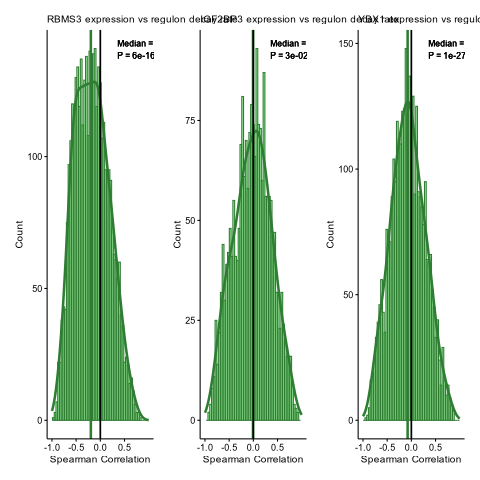

In [73]:
%%R 
hist_plots <- list()

for (rbp_name in names(rbp_results)) {
  result <- rbp_results[[rbp_name]]
  correlations <- result$correlations
  n <- length(correlations)
  binwidth <- (max(correlations) - min(correlations)) / 50  # Force matching histogram binwidth

  hist_plots[[rbp_name]] <- ggplot(data.frame(correlation = correlations), aes(x = correlation)) +
    geom_histogram(binwidth = binwidth, fill = "#90EE90", color = "#2E7D32", 
                   alpha = 0.8, linewidth = 0.5) +
    geom_density(aes(y = after_stat(density) * n * binwidth),
                 color = "#2E7D32", fill = NA, linewidth = 1.2, adjust = 1.5) +
    geom_vline(xintercept = result$median_cor, color = "#2E7D32", 
               linetype = "solid", linewidth = 1.2) +
    geom_vline(xintercept = 0, color = "black", linewidth = 0.8) +
    annotate("text", x = 0.35, y = Inf, vjust = 1.5, hjust = 0,
             label = sprintf("Median = %.2f\nP = %.0e", result$median_cor, result$p_value),
             size = 3, family = "sans",
             bbox = list(boxstyle = "square,pad=0.3", facecolor = "white", alpha = 0.8)) +
    scale_x_continuous(limits = c(-1, 1), breaks = seq(-1, 0.5, 0.5)) +
    theme_classic() +
    labs(title = paste(rbp_name, "expression vs regulon decay rate"),
         x = "Spearman Correlation",
         y = "Count") +
    theme(
      panel.background = element_rect(fill = "white"),
      panel.grid = element_blank(),
      axis.line = element_line(color = "black", linewidth = 0.5),
      axis.ticks = element_line(color = "black", linewidth = 0.5),
      axis.text = element_text(color = "black", size = 9),
      axis.title = element_text(color = "black", size = 10),
      plot.title = element_text(size = 10, face = "plain"),
      plot.margin = margin(t = 10, r = 10, b = 10, l = 10)
    )
}

p_hist <- wrap_plots(hist_plots, ncol = 3)
ggsave("results/rbp_comparison_histograms.pdf", p_hist, width = 12, height = 5)
print(p_hist)

### Create a volcano plot

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [75]:
exp_df = pd.read_csv('data/BRCA_SLAM_gs_TPM.selected.txt', sep="\t", index_col=0)
exp_df = exp_df.loc[exp_df.sum(axis=1)>10,]
exp_df = np.log10(exp_df + 1e-6)
exp_df.head()

,HCC1806-PAR-1,HCC1806-PAR-2,MDA-PAR-1,MDA-PAR-2,MCF7-1,MCF7-2,MDA-MD-453-1,MDA-MD-453-2,HCC38-1,HCC38-2,ZR-75-1,ZR-75-2
GENE,,,,,,,,,,,,
A1BG,1.352520,1.353212,0.561130,0.562999,0.438121,0.391722,1.158195,1.280572,0.825173,0.981491,1.248863,1.125386
AAAS,0.044358,0.164927,-0.085645,0.240688,-0.012887,-0.054587,-0.066918,0.145048,0.192854,0.280589,0.208969,0.062319
AACS,0.534145,0.616855,0.526016,0.569601,0.758398,0.710714,0.553772,0.592084,0.680561,0.741635,0.840785,0.935845
AAED1,0.596877,0.662339,0.660540,0.688598,0.526909,0.441211,-0.068981,0.124260,0.355065,0.561544,0.290039,0.315982
AAGAB,0.623690,0.753050,0.475499,0.563754,0.956415,1.058104,1.041304,1.141294,0.740448,1.019033,1.213546,0.765552


In [76]:
import re
decay_df = pd.read_csv('data/BRCA-lines_log10_decay_rates_gs.txt', sep="\t", index_col=0)
decay_df.columns = [re.sub("\.", "-", x) for x in decay_df.columns]
decay_df.head()

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/avicenna/tmp/ipykernel_2390/2244804436.py:3: SyntaxWarning: invalid escape sequence '\.'
  decay_df.columns = [re.sub("\.", "-", x) for x in decay_df.columns]


,HCC1806-PAR-1,HCC1806-PAR-2,MDA-PAR-1,MDA-PAR-2,MCF7-1,MCF7-2,MDA-MD-453-1,MDA-MD-453-2,HCC38-1,HCC38-2,ZR-75-1,ZR-75-2
A1BG,-1.066082,-1.280269,-0.285732,-0.639637,-0.326187,-0.664953,-0.719758,-0.812882,-1.439074,-0.731446,-1.717306,-1.054118
AACS,-0.125061,-0.058180,0.045117,-0.005526,-0.376835,-0.221019,0.063778,-0.058493,-0.308672,-0.569838,-0.351516,-0.318399
AAED1,-0.171404,-0.180253,0.074135,-0.004023,0.107655,0.336408,0.954444,0.670258,0.320970,-0.151047,0.191012,-0.197516
AAGAB,-0.400829,-0.165416,0.289347,-0.061730,-0.661292,-0.556470,-0.429905,-0.536963,-0.429548,-0.822612,-1.262680,-0.806532
AAK1,-1.045263,-0.947986,-0.742636,-0.721529,-0.451813,-0.670308,-0.605175,-0.498851,-0.723403,-0.852025,-0.914979,-0.630247


<Axes: >

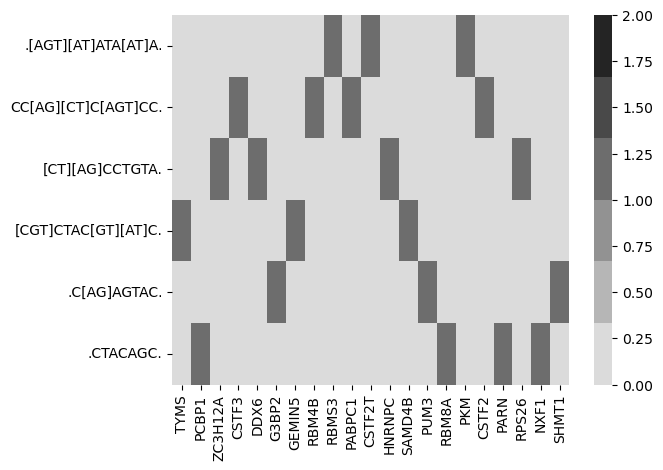

In [82]:
rbp_seq_hyper_df = pd.read_csv('results/rbp_motifs_int_map_df_norm_cut.txt', sep="\t", index_col=0)
rbp_seq_hyper_df[rbp_seq_hyper_df<0] = 0
rbp_seq_hyper_df[rbp_seq_hyper_df>=1.69] = 1
sns.heatmap(rbp_seq_hyper_df, vmin=0, vmax=2, cmap=sns.color_palette("gray_r"))

In [83]:
rbp_seq_hyper_df_long = rbp_seq_hyper_df.reset_index().melt(id_vars='index', value_vars=rbp_seq_hyper_df.columns, var_name='RBP', value_name='edge').query("edge==1")
rbp_seq_hyper_df_long.columns = ['motif', 'RBP', 'edge']
rbp_seq_hyper_df_long.head()

,motif,RBP,edge
3,[CGT]CTAC[GT][AT]C.,TYMS,1.0
11,.CTACAGC.,PCBP1,1.0
14,[CT][AG]CCTGTA.,ZC3H12A,1.0
19,CC[AG][CT]C[AGT]CC.,CSTF3,1.0
26,[CT][AG]CCTGTA.,DDX6,1.0


In [85]:
motif_map_df = pd.read_csv('results/motifs_target_map_df.txt', sep="\t", index_col=0)
motif_map_df.head()

,[CT][AG]CCTGTA.,.[AGT][AT]ATA[AT]A.,CC[AG][CT]C[AGT]CC.,[ACG]TACT[AT][AC][AC][AGT],[CGT]CTAC[GT][AT]C.,.CTACAGC.,.C[AG]AGTAC.
AACS,0,1,1,0,0,0,1
AAED1,0,1,1,0,0,0,0
AAGAB,0,1,0,0,0,0,0
AAMP,0,1,1,0,0,0,0
AAR2,0,0,0,0,0,0,1


In [90]:
## Use the median of the regulon and wilcoxon test
from scipy.stats import spearmanr
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon

exp_decay_corr_dict = defaultdict(dict)
exp_decay_corp_dict = defaultdict(dict)
for mo,rbp in zip(rbp_seq_hyper_df_long.motif, rbp_seq_hyper_df_long.RBP):
    reg = motif_map_df.index[motif_map_df.loc[:,mo]==1].to_list()
    rbp_exp = exp_df.loc[rbp,]
    Rs = []
    for gene in reg:
        gene_dr = decay_df.loc[gene,]
        Rs.append(spearmanr(rbp_exp, gene_dr)[0])
    exp_decay_corr_dict[rbp][mo] = np.median(Rs)
    exp_decay_corp_dict[rbp][mo] = -np.log10(wilcoxon(Rs)[1])

In [ ]:
from collections import defaultdict

# Temporary dict to track best RBP per motif
motif_best_rbp = {}

for rbp in exp_decay_corr_dict:
    for motif in exp_decay_corr_dict[rbp]:
        current_score = exp_decay_corp_dict[rbp][motif]  # -log10(p)
        if motif not in motif_best_rbp:
            motif_best_rbp[motif] = (rbp, current_score)
        else:
            # Keep the more significant (higher -log10P)
            if current_score > motif_best_rbp[motif][1]:
                motif_best_rbp[motif] = (rbp, current_score)

# Now create filtered dicts
filtered_corr_dict = defaultdict(dict)
filtered_corp_dict = defaultdict(dict)

for motif, (rbp, _) in motif_best_rbp.items():
    filtered_corr_dict[rbp][motif] = exp_decay_corr_dict[rbp][motif]
    filtered_corp_dict[rbp][motif] = exp_decay_corp_dict[rbp][motif]

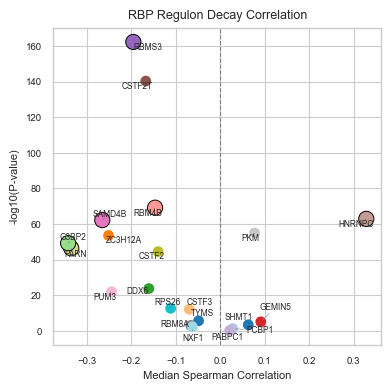

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Create full DataFrame
all_points = []
for rbp in exp_decay_corr_dict:
    for motif in exp_decay_corr_dict[rbp]:
        all_points.append({
            "RBP": rbp,
            "Motif": motif,
            "Median_Correlation": exp_decay_corr_dict[rbp][motif],
            "-log10_P": exp_decay_corp_dict[rbp][motif]
        })
df_all = pd.DataFrame(all_points)

# Create filtered (highlighted) DataFrame
filtered_points = []
for rbp in filtered_corr_dict:
    for motif in filtered_corr_dict[rbp]:
        filtered_points.append({
            "RBP": rbp,
            "Motif": motif,
            "Median_Correlation": filtered_corr_dict[rbp][motif],
            "-log10_P": filtered_corp_dict[rbp][motif]
        })
df_filtered = pd.DataFrame(filtered_points)

# Create a shared color palette
unique_rbps = df_all["RBP"].unique()
palette = dict(zip(unique_rbps, sns.color_palette("tab20", n_colors=len(unique_rbps))))

# Set plot style
sns.set(style="whitegrid", context="paper")
plt.figure(figsize=(4, 4))

# Base layer: all points
sns.scatterplot(
    data=df_all,
    x="Median_Correlation",
    y="-log10_P",
    hue="RBP",
    palette=palette,
    s=60,
    linewidth=0,
    legend=False
)

# Highlighted layer: filtered points
sns.scatterplot(
    data=df_filtered,
    x="Median_Correlation",
    y="-log10_P",
    hue="RBP",
    palette=palette,
    s=120,
    edgecolor="black",
    linewidth=0.7,
    legend=False
)

# Label all points
texts = []
for _, row in df_all.iterrows():
    texts.append(
        plt.text(row["Median_Correlation"], row["-log10_P"], row["RBP"],
                 fontsize=6, ha='center', va='center')
    )
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.4))

# Axes and labels
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel("Median Spearman Correlation", fontsize=8)
plt.ylabel("-log10(P-value)", fontsize=8)
plt.title("RBP Regulon Decay Correlation", fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()

# Save
plt.savefig("results/rbp_decay_scatter_highlighted_labels.pdf", dpi=300)
plt.show()